# Heaps, Heapsort and ADT Priority Queue

### Helper function to display an array as a nearly complete binary tree

Every 1-indexed array can be interpreted as a nearly complete binary tree and vice versa. Since python lists are 0-indexed arrays, we simply assume that position 0 is not used (ignore it).

The following code introduces a helper function `show_array_as_tree(a, N)` that takes an array `a` as input and depicts the elements `a[1]`, ..., `a[N]` as a tree. It is not necessary that you understand the internals of this function (but you need to use a kernel for the notebook where the environment has `networkx` and `matplotlib` installed, e.g. `Python [conda env:python_algodat_env]` on the Uni Basel jupyter hub).

In [1]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import math

def _build_graph(g, a, k, x_pos, N):
    height = math.floor(math.log(N+1, 2)) # Height of the tree
    depth = math.floor(math.log(k, 2)) # Depth of the current node k
    if k > N:
        return
    else:
        y = (height - depth)
        g.add_node(k, pos=(x_pos, y), label=str(a[k]))
        if k > 1: g.add_edge(k, k // 2)
        _build_graph(g, a, k * 2 , x_pos - 2**(height - depth), N)
        _build_graph(g, a, k * 2 + 1, x_pos + 2**(height - depth),  N)
        
    
def show_array_as_tree(a, N=None):
    if N is None:
        N = len(a) - 1
    g = nx.Graph()
    _build_graph(g, a, 1, len(a) / 2 + 1, N)
    pos=nx.get_node_attributes(g,'pos')
    labels = nx.get_node_attributes(g, 'label')
    
    nx.draw_networkx_nodes(g, pos, node_size=1000, node_color='#00b4d9')
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels)
    plt.show()

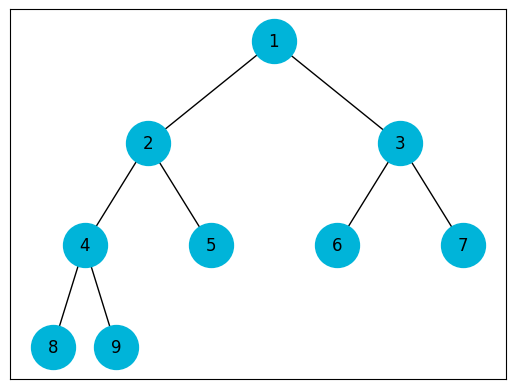

In [2]:
show_array_as_tree([None, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Heaps

#### Helper functions sink and swim

We first introduce a number of helper functions that we will later use when creating a heap, inserting an element and removing the largest element.

In [3]:
def left(i):
    return 2 * i
    
def right(i):
    return 2 * i + 1
    
def parent(i):
    return i // 2

Function `sink` lets an entry with a too small key recursively "float down" into the subtree (which must be a heap) with the larger key at its root. Parameter `heap_size` allows us to indicate that the actual heap in `heap` only reaches to position `heap_size` and the other positions should be ignored.

In [4]:
def sink(heap, i, heap_size=None):
    if heap_size is None:
        heap_size = len(heap) - 1

    l = left(i)
    r = right(i)

    if l <= heap_size and heap[l] > heap[i]:
        largest = l
    else:
        largest = i
    if r <= heap_size and heap[r] > heap[largest]:
        largest = r
    if largest != i:
        heap[i], heap[largest] = heap[largest], heap[i]
        sink(heap, largest, heap_size)

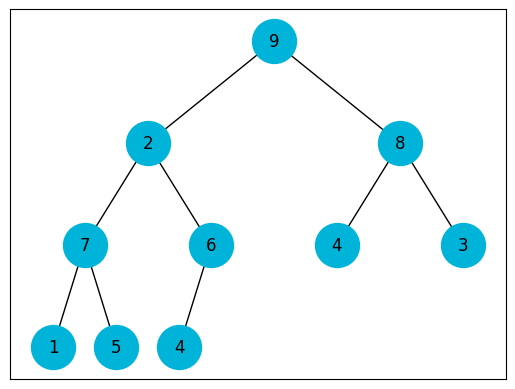

In [5]:
almost_max_heap = [None, 9, 2, 8, 7, 6, 4, 3, 1, 5, 4] 
show_array_as_tree(almost_max_heap)
# entry 2 at position 2 violates the heap property

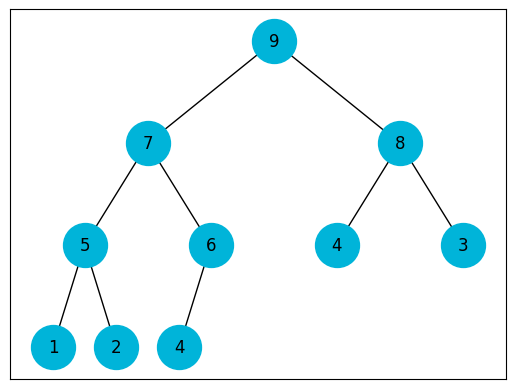

In [6]:
sink(almost_max_heap, 2)
show_array_as_tree(almost_max_heap)

Function `swim` lets an entry with a too large key float up in a tree that is otherwise a heap.

In [7]:
def swim(heap, i):
    parent_index = parent(i)
    # as long as i is not the root and the parent
    # of i has a smaller key than i
    while i > 1 and heap[parent_index] < heap[i]:
        # swap the entries of nodes i and its parent
        heap[parent_index], heap[i] = heap[i], heap[parent_index]
        
        # continue floating up the entry from the parent
        i = parent_index
        parent_index = parent(i)

Let's try the function:

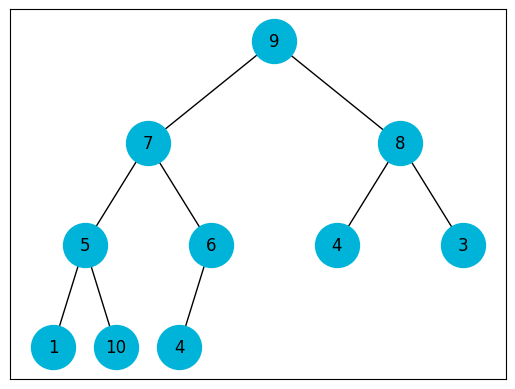

In [8]:
almost_max_heap = [None, 9, 7, 8, 5, 6, 4, 3, 1, 10, 4]
show_array_as_tree(almost_max_heap)
# entry 10 at position 9 violates the heap property

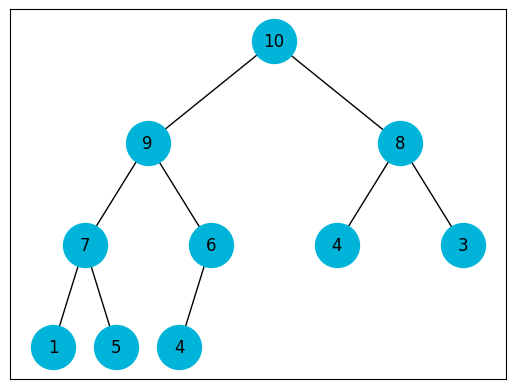

In [9]:
swim(almost_max_heap, 9)
show_array_as_tree(almost_max_heap)

#### Building a heap
We can use `sink` to transform any array into a max-heap in a
bottom-up fashion, processing all nodes from the second-lowest
layer up to the root.

In [10]:
def build_max_heap(array):
    heap_size = len(array) - 1

    # all elements from positions heap_size//2 + 1
    # to heap_size are leaves of the tree.
    for i in range(heap_size//2, 0, -1):
        # print(i)
        # show_array_as_tree(array)
        sink(array, i, heap_size)


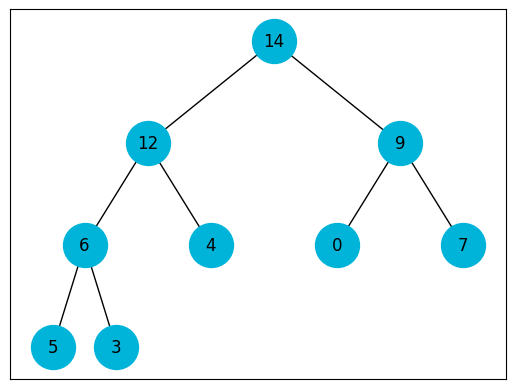

In [11]:
array = [None, 3, 5, 7, 12, 4, 0, 9, 14, 6]
build_max_heap(array)
show_array_as_tree(array)

#### Retreiving and removing the largest element

It is trivial to determine the largest element in a max-heap because it will always be found at the root:

In [12]:
def max_heap_maximum(heap, heap_size):
    if heap_size < 1:
        raise Exception("determining maximum element from empty heap")
    else:
        return heap[1]

In [13]:
# Example
array = [None, 3, 5, 7, 12, 4, 0, 9, 14, 6]
build_max_heap(array)
max_heap_maximum(array, len(array)-1)

14

If we want to remove the maximum, we fill the position with the
bottom-right element and restore the heap property with sink
on position 1.

In [14]:
def max_heap_extract_max(heap, heap_size):
    if heap_size is None:
        heap_size = len(heap) - 1
    maximum = max_heap_maximum(heap, heap_size)
    heap[1] = heap[heap_size]
    sink(heap, 1, heap_size)
    return maximum
    # the externally handled heap_size
    # needs to be decremented

14


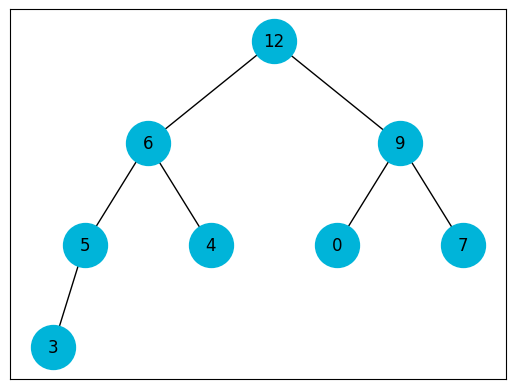

In [15]:
array = [None, 3, 5, 7, 12, 4, 0, 9, 14, 6]
build_max_heap(array)
heap_size = len(array) - 1
print(max_heap_extract_max(array, heap_size))
heap_size -= 1
show_array_as_tree(array, heap_size)

#### Adding an entry
To add an entry, we insert it as a new leaf and let it swim to re-establish the heap property.

In [16]:
def max_heap_insert(heap, item, heap_size=None):
    if heap_size is None:
        heap_size = len(heap) - 1
    if heap_size < len(heap) - 1:
        # we still have space in the array
        heap[heap_size + 1] = item
    else:
        assert heap_size == len(heap) - 1
        heap.append(item)
    swim(heap, heap_size + 1)

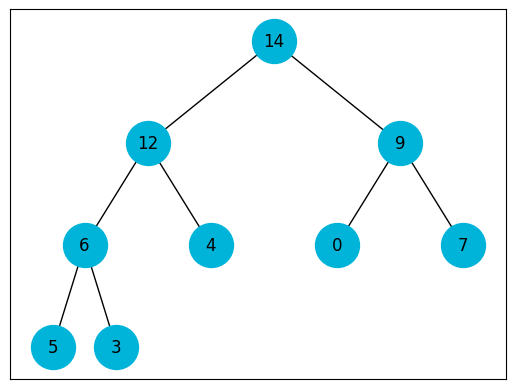

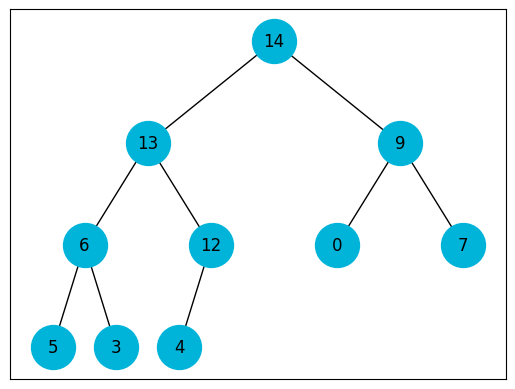

In [17]:
array = [None, 3, 5, 7, 12, 4, 0, 9, 14, 6]
build_max_heap(array)
heap_size = len(array) - 1
show_array_as_tree(array, heap_size)
max_heap_insert(array, 13, heap_size)
heap_size = heap_size + 1
show_array_as_tree(array, heap_size)

## Heapsort

Heapsort successively swaps the largest element to the end of the non-sorted range. To determine the largest element, we use a heap. 

*Observation*: We can represent the heap directly in the input sequence, so
that heap sort only needs constant additional storage.

In [18]:
# assumes that array[0] is not part of the input sequence
def heapsort(array):
    build_max_heap(array)
    # i ranges from last position down to position 1
    for i in range(len(array) - 1, 0, -1): 
        # swap largest element from heap to position i
        array[i], array[1] = array[1], array[i]
        # restore heap_property for heap (in range 1,...,i-1)
        sink(array, 1, i-1)

In [19]:
array = [None, 3, 5, 6, 2, 7, 0]
heapsort(array)
print(array)

[None, 0, 2, 3, 5, 6, 7]


## Priority queues

#### Implementing a priority queue with a heap

We implement a priority queue with a heap. 
As for sorting algorithms, we will assume in the example implementations that the items and the keys are identical.

##### Exercise
Implement the abstract datatype priority queue by means of a heap.

In [20]:
class PQ:
    def __init__(self):
        self.data = [None] # the heap data structure
        self.heap_size = 0

    def is_empty(self):
        return self.heap_size == 0

    def size(self):
        return self.heap_size

    def insert(self, item):
        # assuming that the item and its key are identical
        max_heap_insert(self.data, item, self.heap_size)
        self.heap_size += 1

    def maximum(self):
        if self.is_empty():
            raise Exception("invalid operation on empty pq")
        return max_heap_maximum(self.data, self.heap_size)

    def extract_max(self):
        if self.is_empty():
            raise Exception("invalid operation on empty pq")
        maximum = max_heap_extract_max(self.data, self.heap_size)
        self.heap_size -= 1
        return maximum

In [21]:
# try it:
pq = PQ()
pq.insert(4)
pq.insert(2)
pq.insert(5)
pq.insert(3)
maximum = pq.extract_max()
print("Maximum:", maximum)
pq.insert(6)
pq.insert(1)
print("Extract all elements from largest to smallest:")
while not pq.is_empty():
    print(pq.extract_max())

Maximum: 5
Extract all elements from largest to smallest:
6
4
3
2
1
